In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam, AdamW, RAdam
from torch.nn.parameter import Parameter
from torch.nn import NLLLoss, BCEWithLogitsLoss
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torchvision
from torch.nn import Module
import torch.nn.functional as F
from torch.nn import Conv2d, Dropout2d, Linear, Dropout
from torch import cat
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from datetime import datetime
import pprint

d:\miniconda3\Lib\site-packages\pennylane\__init__.py:196: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.0 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
        #torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        ])


train_ds = torchvision.datasets.FashionMNIST(
    "./", train=True, download=True,
    transform=transform)

test_ds = torchvision.datasets.FashionMNIST(
    "./", train=False, download=True,
    transform=transform)


train_mask = (train_ds.targets == 0) | (train_ds.targets == 6)
train_idx = torch.where(train_mask)[0]
train_ds.targets[train_ds.targets == 6] = 1

batch_size = 50

binary_train_ds = Subset(train_ds, train_idx)
train_loader = DataLoader(binary_train_ds, batch_size = batch_size, shuffle =True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [20]:
torch.set_default_dtype(torch.float64)
class BinaryClassifier(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 8, kernel_size=5, padding=2)
        self.conv2 = Conv2d(8, 25, kernel_size=5, padding=2)
        self.dropout = Dropout2d()
        self.fc1 = Linear(25 * 7 * 7, 36)
        self.fn_dropout = Dropout(p=0.1)
        self.fc2 = Linear(36, 2)
        self.fc3 = Linear(2, 1)

        # Quantum layer
        self.num_q_wires = 2
        self.q_device = qml.device("default.qubit", wires=self.num_q_wires)
        
        self.num_q_layers = 2
        qnn_params_size = (self.num_q_layers * 3 + 2) * self.num_q_wires
        qnn_params_tensor = torch.empty(qnn_params_size, requires_grad=True)

        # Kaiming 초기화의 gain 값 계산 (SiLU에 적합한 'leaky_relu'를 사용)
        gain = torch.nn.init.calculate_gain('leaky_relu')
        std = gain / qnn_params_size**0.5 # 텐서 크기를 이용한 표준 편차 계산
        
        # 균등 분포로 파라미터 초기화
        torch.nn.init.uniform_(qnn_params_tensor, -std, std)

        self.qnn_params = Parameter(qnn_params_tensor)

        #@qml.qnode(self.q_device)
        @qml.qnode(self.q_device, interface="torch")
        def circuit(x_batch):
            param_idx = 0 
            for layer in range(self.num_q_layers): # num_q_layers 만큼 반복
                for i in range(self.num_q_wires):
                    qml.H(wires=i)
                    qml.RZ(2. * x_batch[:, i], wires=i)
                    
                for i in range(self.num_q_wires):
                    qml.CRZ(2. * (torch.pi - x_batch[:, i]) * (torch.pi - x_batch[:, (i+1) % self.num_q_wires]), wires=[i, (i+1)%self.num_q_wires])

                # EfficientSU2
                for i in range(self.num_q_wires):
                    qml.RY(self.qnn_params[param_idx], wires=i)
                    param_idx += 1
                    qml.RX(self.qnn_params[param_idx], wires=i)
                    param_idx += 1
                    #qml.Rot(self.qnn_params[param_idx], self.qnn_params[param_idx+1], torch.tensor(-torch.pi/2, dtype=torch.float64), wires=i)
                    #param_idx += 2
                    qml.Y(wires=i)

                for i in range(self.num_q_wires):
                    qml.CRX(self.qnn_params[param_idx], wires=[i, (i+1)%self.num_q_wires])
                    param_idx += 1
                    #qml.CNOT(wires=[i, (i+1)%self.num_q_wires])

                #for i in range(self.num_q_wires):
                #    qml.Z(wires=i)
                
                if layer == self.num_q_layers-1:
                    for i in range(self.num_q_wires):
                        qml.RY(self.qnn_params[param_idx], wires=i)
                        param_idx += 1
                        qml.RX(self.qnn_params[param_idx], wires=i)
                        param_idx += 1
                        #qml.Rot(self.qnn_params[param_idx], self.qnn_params[param_idx+1], torch.tensor(-torch.pi/2, dtype=torch.float64), wires=i)
                        #param_idx += 2
                        qml.Y(wires=i)
            
            #return qml.expval(self.obs) # qml.expval은 이제 (BATCH_SIZE,) 형태를 반환
            return [qml.expval(qml.PauliZ(i)) for i in range(self.num_q_wires)]

        self.qnn = circuit

    def forward(self, x):
        #x = F.silu(self.conv1(x))
        x = F.leaky_relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        
        #x = F.silu(self.conv2(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)
        
        #x = F.silu(self.fc1(x))
        x = F.leaky_relu(self.fc1(x))
        #x = F.dropout(x, p=0.1)
        x = self.fn_dropout(x)

        x = self.fc2(x)
        
        #x = self.qnn(x).view(1,)  # apply QNN
        qnn_out = self.qnn(x) 
        x = torch.stack(qnn_out, dim=-1).to(x.device)
        
        x = self.fc3(x)
        return F.log_softmax(cat((x, 1 - x), -1), -1)

bc = BinaryClassifier()
bc.to(device)

BinaryClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1225, out_features=36, bias=True)
  (fn_dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=36, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=1, bias=True)
)

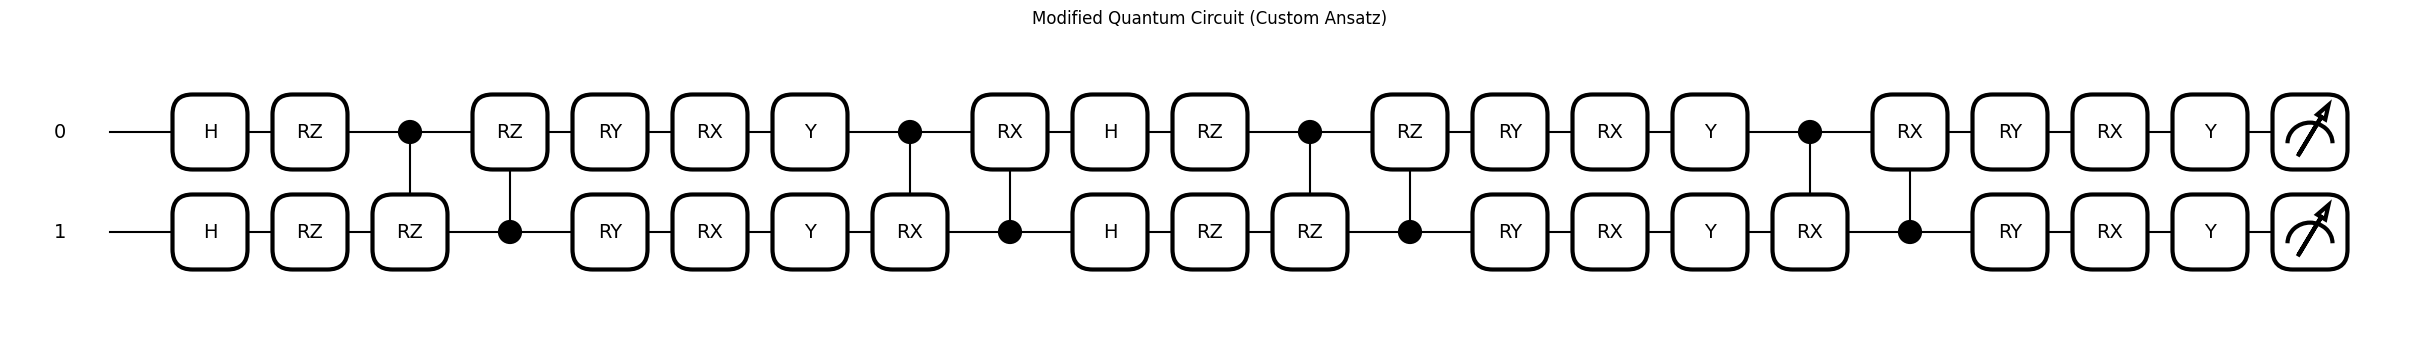

In [21]:
dummy_x = torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], dtype=torch.float64).to(device)
specs = qml.specs(bc.qnn)(dummy_x)
total_params = sum(p.numel() for p in bc.parameters() if p.requires_grad)

# 양자 회로 그리기
fig, ax = qml.draw_mpl(bc.qnn)(dummy_x)
plt.title("Modified Quantum Circuit (Custom Ansatz)")
plt.show()

In [22]:
pprint.pprint(specs, width=1)
print(total_params)
assert specs["num_tape_wires"] <= 8,  "❌ 큐빗 수 초과"
assert specs['resources'].depth <= 30, "❌ 회로 깊이 초과"
assert specs["num_trainable_params"]<= 60, "❌ 학습 퀀텀 파라미터 수 초과"
assert total_params <= 50000, "❌ 학습 전체 파라미터 수 초과"

print("✅ 회로 제약 통과 — 학습을 계속합니다")

{'device_name': 'default.qubit',
 'diff_method': 'best',
 'errors': {},
 'gradient_fn': 'backprop',
 'gradient_options': {},
 'interface': 'torch',
 'level': 'gradient',
 'num_device_wires': 2,
 'num_observables': 2,
 'num_tape_wires': 2,
 'num_trainable_params': 16,
 'resources': Resources(num_wires=2,
                        num_gates=34,
                        gate_types=defaultdict(<class 'int'>,
                                               {'CRX': 4,
                                                'CRZ': 4,
                                                'Hadamard': 4,
                                                'PauliY': 6,
                                                'RX': 6,
                                                'RY': 6,
                                                'RZ': 4}),
                        gate_sizes=defaultdict(<class 'int'>,
                                               {1: 26,
                                                2: 8}),
         

In [23]:
def train_step(epochs=10, lr=0.0010, weight_decay=1e-6):
    optimizer = AdamW(bc.parameters(), lr=lr, weight_decay=weight_decay)
    loss_func  = NLLLoss()

    scheduler = CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader), eta_min=1e-6)

    loss_history = []
    bc.train()


    print(f"Starting training on {device}...")
    for epoch in range(epochs):
        epoch_bar = tqdm(enumerate(train_loader),
                        desc=f"Epoch {epoch+1}/{epochs}",
                        total=len(train_loader),
                        leave=True)

        total_loss = []
        for bidx, (data, target) in epoch_bar:
            data = data.to(device)
            target = target.to(device).flatten().long()
            #target = target.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad(set_to_none=True)

            output = bc(data)
            loss = loss_func(output, target)

            total_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step()

            if bidx % 100 == 0:
                epoch_bar.set_postfix(batch=bidx,
                                    loss=f"{loss.item():.4f}",
                                    lr=f"{optimizer.param_groups[0]['lr']:.6f}")

        avg_loss = sum(total_loss) / len(total_loss)
        loss_history.append(avg_loss)

        print(f"Training [{100.0 * (epoch+1)/epochs:.0f}%] Loss: {avg_loss:.4f}")
        
    return loss_history


In [24]:
def test():
    print(f"Starting inference on {device}...")
    bc.eval()

    all_preds, all_targets = [], []

    with torch.no_grad():
        for data, target in tqdm(test_loader,
                                desc="Inference",
                                total=len(test_loader),
                                leave=False):
            data, target = data.to(device), target.to(device).flatten().long() #target.to(device).float().unsqueeze(1)

            logits = bc(data)

            pred = logits.argmax(dim=-1)
            #probabilities = torch.sigmoid(logits)
            #pred = (probabilities >= 0.5).float().squeeze(1) 

            all_preds.append(pred.cpu())
            all_targets.append(target.cpu())

    y_pred = torch.cat(all_preds).numpy().astype(int)
    y_true = torch.cat(all_targets).numpy().astype(int)

    #y_pred = torch.cat(all_preds).numpy().flatten().astype(int) # .flatten() 추가
    #y_true = torch.cat(all_targets).numpy().flatten().astype(int) # .flatten() 추가

    # --- 8. 평가 및 결과 저장 ---
    # 베이스라인 평가 로직을 따릅니다. y_true는 이제 10000개 길이를 가집니다.
    test_mask = (y_true == 0) | (y_true == 6)

    print("total samples:", len(y_true))
    print("target samples:", test_mask.sum())

    # 모델 결과가 1인 것을 6으로 변경 (제출 형식에 맞게)
    y_pred_mapped = np.where(y_pred == 1, 6, y_pred)

    # 정확도 계산은 0/6 라벨에 대해서만 수행
    acc = (y_pred_mapped[test_mask] == y_true[test_mask]).mean()
    print(f"accuracy (labels 0/6 only): {acc:.4f}")

    now = datetime.now().strftime("%Y%m%d_%H%M%S")

    y_pred_filename = f"y_pred_{now}.csv"

    return y_pred_mapped, y_pred_filename, acc



In [25]:
def plt_loss_history(loss_history, n_repeats, epochs_per_repeat):
    """
    학습 손실 이력을 시각화합니다.
    Args:
        loss_history (list): 에포크별 평균 손실 값 리스트
        n_repeats (int): train_step 함수의 총 반복 횟수 (n)
        epochs_per_repeat (int): 한 번의 train_step에서 에포크 수 (epochs)
    """
    total_epochs = n_repeats * epochs_per_repeat
    x_axis = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, loss_history)
    plt.title("Training Loss History")
    plt.xlabel("Total Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

# 사용 예시
# loss_history는 모든 반복(n)과 에포크(epochs)의 손실이 담긴 리스트
# loss_history = [ ... ]

# plt_loss_history(loss_history, n_repeats=15, epochs_per_repeat=20)

In [26]:
result = 0
best_result = 0
max_y_pred_filename = ""
best_n = 0
n = 0
epochs = 10
lr = 0.0015
loss_history = []

while result < 0.92:
    lr = 0.0015 * (0.80**n)
    loss_history.extend(train_step(epochs=epochs, lr=lr, weight_decay=batch_size * 1e-6))
    y_pred_mapped, y_pred_filename, result = test()
    print(f"Iteration {n+1}: Result = {result:.4f}")

    if result > best_result:
        best_result = result
        best_n = n
        max_y_pred_filename = y_pred_filename

    n += 1

Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:10<00:00, 22.45it/s, batch=200, loss=0.3739, lr=0.001474]


Training [10%] Loss: 0.4886


Epoch 2/10: 100%|██████████| 240/240 [00:10<00:00, 22.48it/s, batch=200, loss=0.3949, lr=0.001379]


Training [20%] Loss: 0.3781


Epoch 3/10: 100%|██████████| 240/240 [00:11<00:00, 21.64it/s, batch=200, loss=0.3128, lr=0.001221]


Training [30%] Loss: 0.3304


Epoch 4/10: 100%|██████████| 240/240 [00:10<00:00, 22.82it/s, batch=200, loss=0.2873, lr=0.001018]


Training [40%] Loss: 0.3009


Epoch 5/10: 100%|██████████| 240/240 [00:10<00:00, 22.12it/s, batch=200, loss=0.3905, lr=0.000789]


Training [50%] Loss: 0.2784


Epoch 6/10: 100%|██████████| 240/240 [00:11<00:00, 21.42it/s, batch=200, loss=0.2019, lr=0.000556]


Training [60%] Loss: 0.2648


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.67it/s, batch=200, loss=0.4459, lr=0.000341]


Training [70%] Loss: 0.2489


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 21.82it/s, batch=200, loss=0.2724, lr=0.000167]


Training [80%] Loss: 0.2388


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.40it/s, batch=200, loss=0.2653, lr=0.000050]


Training [90%] Loss: 0.2314


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 21.52it/s, batch=200, loss=0.2198, lr=0.000002]


Training [100%] Loss: 0.2243
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8815
Iteration 1: Result = 0.8815
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:11<00:00, 21.80it/s, batch=200, loss=0.3213, lr=0.001179]


Training [10%] Loss: 0.2508


Epoch 2/10: 100%|██████████| 240/240 [00:10<00:00, 23.21it/s, batch=200, loss=0.3917, lr=0.001103]


Training [20%] Loss: 0.2449


Epoch 3/10: 100%|██████████| 240/240 [00:10<00:00, 23.47it/s, batch=200, loss=0.2768, lr=0.000977]


Training [30%] Loss: 0.2389


Epoch 4/10: 100%|██████████| 240/240 [00:10<00:00, 23.29it/s, batch=200, loss=0.2059, lr=0.000815]


Training [40%] Loss: 0.2262


Epoch 5/10: 100%|██████████| 240/240 [00:10<00:00, 23.53it/s, batch=200, loss=0.3116, lr=0.000631]


Training [50%] Loss: 0.2175


Epoch 6/10: 100%|██████████| 240/240 [00:10<00:00, 23.10it/s, batch=200, loss=0.2115, lr=0.000445]


Training [60%] Loss: 0.2045


Epoch 7/10: 100%|██████████| 240/240 [00:10<00:00, 23.84it/s, batch=200, loss=0.1519, lr=0.000273]


Training [70%] Loss: 0.1966


Epoch 8/10: 100%|██████████| 240/240 [00:10<00:00, 23.55it/s, batch=200, loss=0.1546, lr=0.000134]


Training [80%] Loss: 0.1863


Epoch 9/10: 100%|██████████| 240/240 [00:10<00:00, 23.23it/s, batch=200, loss=0.1756, lr=0.000041]


Training [90%] Loss: 0.1821


Epoch 10/10: 100%|██████████| 240/240 [00:10<00:00, 23.02it/s, batch=200, loss=0.1640, lr=0.000002]


Training [100%] Loss: 0.1776
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8865
Iteration 2: Result = 0.8865
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:10<00:00, 23.27it/s, batch=200, loss=0.2401, lr=0.000943]


Training [10%] Loss: 0.2118


Epoch 2/10: 100%|██████████| 240/240 [00:10<00:00, 23.37it/s, batch=200, loss=0.2094, lr=0.000882]


Training [20%] Loss: 0.2075


Epoch 3/10: 100%|██████████| 240/240 [00:10<00:00, 22.85it/s, batch=200, loss=0.1922, lr=0.000782]


Training [30%] Loss: 0.1942


Epoch 4/10: 100%|██████████| 240/240 [00:10<00:00, 23.19it/s, batch=200, loss=0.1985, lr=0.000652]


Training [40%] Loss: 0.1878


Epoch 5/10: 100%|██████████| 240/240 [00:10<00:00, 23.21it/s, batch=200, loss=0.2243, lr=0.000505]


Training [50%] Loss: 0.1823


Epoch 6/10: 100%|██████████| 240/240 [00:10<00:00, 23.24it/s, batch=200, loss=0.1149, lr=0.000356]


Training [60%] Loss: 0.1721


Epoch 7/10: 100%|██████████| 240/240 [00:10<00:00, 23.48it/s, batch=200, loss=0.2297, lr=0.000219]


Training [70%] Loss: 0.1630


Epoch 8/10: 100%|██████████| 240/240 [00:10<00:00, 23.49it/s, batch=200, loss=0.2707, lr=0.000107]


Training [80%] Loss: 0.1584


Epoch 9/10: 100%|██████████| 240/240 [00:10<00:00, 22.86it/s, batch=200, loss=0.2680, lr=0.000033]


Training [90%] Loss: 0.1493


Epoch 10/10: 100%|██████████| 240/240 [00:10<00:00, 23.29it/s, batch=200, loss=0.1495, lr=0.000002]


Training [100%] Loss: 0.1503
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8860
Iteration 3: Result = 0.8860
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:10<00:00, 23.14it/s, batch=200, loss=0.2700, lr=0.000755]


Training [10%] Loss: 0.1754


Epoch 2/10: 100%|██████████| 240/240 [00:10<00:00, 22.88it/s, batch=200, loss=0.1464, lr=0.000706]


Training [20%] Loss: 0.1687


Epoch 3/10: 100%|██████████| 240/240 [00:10<00:00, 23.10it/s, batch=200, loss=0.1209, lr=0.000625]


Training [30%] Loss: 0.1655


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 20.69it/s, batch=200, loss=0.2005, lr=0.000521]


Training [40%] Loss: 0.1598


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.42it/s, batch=200, loss=0.1679, lr=0.000404]


Training [50%] Loss: 0.1589


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.48it/s, batch=200, loss=0.1311, lr=0.000285]


Training [60%] Loss: 0.1465


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.78it/s, batch=200, loss=0.0939, lr=0.000175]


Training [70%] Loss: 0.1380


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.82it/s, batch=200, loss=0.1235, lr=0.000086]


Training [80%] Loss: 0.1322


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.37it/s, batch=200, loss=0.0992, lr=0.000026]


Training [90%] Loss: 0.1311


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.51it/s, batch=200, loss=0.0755, lr=0.000001]


Training [100%] Loss: 0.1259
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8895
Iteration 4: Result = 0.8895
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.36it/s, batch=200, loss=0.1303, lr=0.000604]


Training [10%] Loss: 0.1471


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.77it/s, batch=200, loss=0.1207, lr=0.000565]


Training [20%] Loss: 0.1441


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.32it/s, batch=200, loss=0.2075, lr=0.000500]


Training [30%] Loss: 0.1434


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.73it/s, batch=200, loss=0.1198, lr=0.000417]


Training [40%] Loss: 0.1363


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.76it/s, batch=200, loss=0.1317, lr=0.000323]


Training [50%] Loss: 0.1344


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.52it/s, batch=200, loss=0.1878, lr=0.000228]


Training [60%] Loss: 0.1214


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.79it/s, batch=200, loss=0.1004, lr=0.000140]


Training [70%] Loss: 0.1199


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.28it/s, batch=200, loss=0.1433, lr=0.000069]


Training [80%] Loss: 0.1189


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.31it/s, batch=200, loss=0.1079, lr=0.000021]


Training [90%] Loss: 0.1134


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.81it/s, batch=200, loss=0.1062, lr=0.000001]


Training [100%] Loss: 0.1125
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8910
Iteration 5: Result = 0.8910
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.29it/s, batch=200, loss=0.1087, lr=0.000483]


Training [10%] Loss: 0.1286


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.52it/s, batch=200, loss=0.1220, lr=0.000452]


Training [20%] Loss: 0.1302


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 18.78it/s, batch=200, loss=0.1224, lr=0.000400]


Training [30%] Loss: 0.1202


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.35it/s, batch=200, loss=0.1181, lr=0.000334]


Training [40%] Loss: 0.1196


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.29it/s, batch=200, loss=0.0875, lr=0.000259]


Training [50%] Loss: 0.1166


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.17it/s, batch=200, loss=0.2077, lr=0.000182]


Training [60%] Loss: 0.1128


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.62it/s, batch=200, loss=0.0790, lr=0.000112]


Training [70%] Loss: 0.1043


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.54it/s, batch=200, loss=0.0635, lr=0.000055]


Training [80%] Loss: 0.1018


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.07it/s, batch=200, loss=0.0592, lr=0.000017]


Training [90%] Loss: 0.0985


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.47it/s, batch=200, loss=0.0309, lr=0.000001]


Training [100%] Loss: 0.0978
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8910
Iteration 6: Result = 0.8910
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.40it/s, batch=200, loss=0.0802, lr=0.000386]


Training [10%] Loss: 0.1190


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.42it/s, batch=200, loss=0.1079, lr=0.000361]


Training [20%] Loss: 0.1080


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.72it/s, batch=200, loss=0.1236, lr=0.000320]


Training [30%] Loss: 0.1107


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.11it/s, batch=200, loss=0.0982, lr=0.000267]


Training [40%] Loss: 0.1000


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.62it/s, batch=200, loss=0.1310, lr=0.000207]


Training [50%] Loss: 0.0994


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.65it/s, batch=200, loss=0.0916, lr=0.000146]


Training [60%] Loss: 0.0982


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.99it/s, batch=200, loss=0.1887, lr=0.000090]


Training [70%] Loss: 0.0967


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.78it/s, batch=200, loss=0.1378, lr=0.000045]


Training [80%] Loss: 0.0917


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.47it/s, batch=200, loss=0.0491, lr=0.000014]


Training [90%] Loss: 0.0866


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.77it/s, batch=200, loss=0.0772, lr=0.000001]


Training [100%] Loss: 0.0889
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8960
Iteration 7: Result = 0.8960
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.45it/s, batch=200, loss=0.0302, lr=0.000309]


Training [10%] Loss: 0.0993


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.37it/s, batch=200, loss=0.0823, lr=0.000289]


Training [20%] Loss: 0.1037


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.51it/s, batch=200, loss=0.1450, lr=0.000256]


Training [30%] Loss: 0.1019


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.36it/s, batch=200, loss=0.1215, lr=0.000214]


Training [40%] Loss: 0.0936


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.29it/s, batch=200, loss=0.0877, lr=0.000166]


Training [50%] Loss: 0.0883


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.34it/s, batch=200, loss=0.0592, lr=0.000117]


Training [60%] Loss: 0.0961


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.01it/s, batch=200, loss=0.0890, lr=0.000072]


Training [70%] Loss: 0.0829


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.51it/s, batch=200, loss=0.1017, lr=0.000036]


Training [80%] Loss: 0.0825


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.42it/s, batch=200, loss=0.0975, lr=0.000011]


Training [90%] Loss: 0.0856


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.54it/s, batch=200, loss=0.0729, lr=0.000001]


Training [100%] Loss: 0.0809
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.9005
Iteration 8: Result = 0.9005
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.62it/s, batch=200, loss=0.0618, lr=0.000247]


Training [10%] Loss: 0.0932


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.53it/s, batch=200, loss=0.0676, lr=0.000231]


Training [20%] Loss: 0.0925


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.49it/s, batch=200, loss=0.1126, lr=0.000205]


Training [30%] Loss: 0.0883


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.76it/s, batch=200, loss=0.0468, lr=0.000171]


Training [40%] Loss: 0.0856


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.47it/s, batch=200, loss=0.0814, lr=0.000133]


Training [50%] Loss: 0.0869


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.50it/s, batch=200, loss=0.0561, lr=0.000094]


Training [60%] Loss: 0.0860


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.07it/s, batch=200, loss=0.0240, lr=0.000058]


Training [70%] Loss: 0.0777


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.64it/s, batch=200, loss=0.0417, lr=0.000029]


Training [80%] Loss: 0.0791


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.34it/s, batch=200, loss=0.1183, lr=0.000009]


Training [90%] Loss: 0.0759


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.70it/s, batch=200, loss=0.0426, lr=0.000001]


Training [100%] Loss: 0.0743
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8985
Iteration 9: Result = 0.8985
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.57it/s, batch=200, loss=0.0575, lr=0.000198]


Training [10%] Loss: 0.0819


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.50it/s, batch=200, loss=0.1343, lr=0.000185]


Training [20%] Loss: 0.0824


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.55it/s, batch=200, loss=0.0548, lr=0.000164]


Training [30%] Loss: 0.0828


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.70it/s, batch=200, loss=0.1043, lr=0.000137]


Training [40%] Loss: 0.0827


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.88it/s, batch=200, loss=0.0471, lr=0.000106]


Training [50%] Loss: 0.0763


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.35it/s, batch=200, loss=0.1070, lr=0.000075]


Training [60%] Loss: 0.0812


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.70it/s, batch=200, loss=0.1176, lr=0.000047]


Training [70%] Loss: 0.0742


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.70it/s, batch=200, loss=0.0163, lr=0.000023]


Training [80%] Loss: 0.0710


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.26it/s, batch=200, loss=0.0271, lr=0.000008]


Training [90%] Loss: 0.0804


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 18.56it/s, batch=200, loss=0.1582, lr=0.000001]


Training [100%] Loss: 0.0750
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8985
Iteration 10: Result = 0.8985
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.56it/s, batch=200, loss=0.1571, lr=0.000158]


Training [10%] Loss: 0.0807


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.72it/s, batch=200, loss=0.0840, lr=0.000148]


Training [20%] Loss: 0.0804


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.39it/s, batch=200, loss=0.0496, lr=0.000131]


Training [30%] Loss: 0.0726


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.51it/s, batch=200, loss=0.1096, lr=0.000110]


Training [40%] Loss: 0.0764


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.51it/s, batch=200, loss=0.0175, lr=0.000085]


Training [50%] Loss: 0.0721


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.55it/s, batch=200, loss=0.1028, lr=0.000060]


Training [60%] Loss: 0.0720


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.72it/s, batch=200, loss=0.1350, lr=0.000037]


Training [70%] Loss: 0.0735


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.60it/s, batch=200, loss=0.0679, lr=0.000019]


Training [80%] Loss: 0.0712


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.63it/s, batch=200, loss=0.0700, lr=0.000006]


Training [90%] Loss: 0.0671


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.35it/s, batch=200, loss=0.1363, lr=0.000001]


Training [100%] Loss: 0.0689
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8995
Iteration 11: Result = 0.8995
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.64it/s, batch=200, loss=0.0249, lr=0.000127]


Training [10%] Loss: 0.0745


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.76it/s, batch=200, loss=0.1214, lr=0.000118]


Training [20%] Loss: 0.0710


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.47it/s, batch=200, loss=0.2204, lr=0.000105]


Training [30%] Loss: 0.0723


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.41it/s, batch=200, loss=0.0387, lr=0.000088]


Training [40%] Loss: 0.0750


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.69it/s, batch=200, loss=0.0997, lr=0.000068]


Training [50%] Loss: 0.0717


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.38it/s, batch=200, loss=0.0625, lr=0.000048]


Training [60%] Loss: 0.0705


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.77it/s, batch=200, loss=0.0546, lr=0.000030]


Training [70%] Loss: 0.0663


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.51it/s, batch=200, loss=0.0301, lr=0.000015]


Training [80%] Loss: 0.0669


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.75it/s, batch=200, loss=0.0377, lr=0.000005]


Training [90%] Loss: 0.0666


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.55it/s, batch=200, loss=0.0586, lr=0.000001]


Training [100%] Loss: 0.0673
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8985
Iteration 12: Result = 0.8985
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.58it/s, batch=200, loss=0.1243, lr=0.000101]


Training [10%] Loss: 0.0704


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.54it/s, batch=200, loss=0.0542, lr=0.000095]


Training [20%] Loss: 0.0732


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.46it/s, batch=200, loss=0.0692, lr=0.000084]


Training [30%] Loss: 0.0696


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.50it/s, batch=200, loss=0.0288, lr=0.000070]


Training [40%] Loss: 0.0637


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.45it/s, batch=200, loss=0.0207, lr=0.000055]


Training [50%] Loss: 0.0698


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 18.98it/s, batch=200, loss=0.1444, lr=0.000039]


Training [60%] Loss: 0.0633


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.90it/s, batch=200, loss=0.0457, lr=0.000024]


Training [70%] Loss: 0.0638


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.74it/s, batch=200, loss=0.0541, lr=0.000012]


Training [80%] Loss: 0.0669


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.45it/s, batch=200, loss=0.0559, lr=0.000004]


Training [90%] Loss: 0.0628


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.79it/s, batch=200, loss=0.0495, lr=0.000001]


Training [100%] Loss: 0.0628
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8980
Iteration 13: Result = 0.8980
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.22it/s, batch=200, loss=0.0761, lr=0.000081]


Training [10%] Loss: 0.0673


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 20.07it/s, batch=200, loss=0.0167, lr=0.000076]


Training [20%] Loss: 0.0676


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.31it/s, batch=200, loss=0.0522, lr=0.000067]


Training [30%] Loss: 0.0672


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.55it/s, batch=200, loss=0.0353, lr=0.000056]


Training [40%] Loss: 0.0665


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.52it/s, batch=200, loss=0.0759, lr=0.000044]


Training [50%] Loss: 0.0655


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.61it/s, batch=200, loss=0.0455, lr=0.000031]


Training [60%] Loss: 0.0662


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.94it/s, batch=200, loss=0.0156, lr=0.000020]


Training [70%] Loss: 0.0641


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.68it/s, batch=200, loss=0.0341, lr=0.000010]


Training [80%] Loss: 0.0608


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.60it/s, batch=200, loss=0.0069, lr=0.000004]


Training [90%] Loss: 0.0599


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.57it/s, batch=200, loss=0.0465, lr=0.000001]


Training [100%] Loss: 0.0631
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8985
Iteration 14: Result = 0.8985
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.39it/s, batch=200, loss=0.1023, lr=0.000065]


Training [10%] Loss: 0.0646


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.73it/s, batch=200, loss=0.0985, lr=0.000061]


Training [20%] Loss: 0.0622


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.55it/s, batch=200, loss=0.0742, lr=0.000054]


Training [30%] Loss: 0.0614


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.89it/s, batch=200, loss=0.0109, lr=0.000045]


Training [40%] Loss: 0.0614


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.25it/s, batch=200, loss=0.1097, lr=0.000035]


Training [50%] Loss: 0.0598


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.37it/s, batch=200, loss=0.0244, lr=0.000025]


Training [60%] Loss: 0.0652


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.34it/s, batch=200, loss=0.0459, lr=0.000016]


Training [70%] Loss: 0.0574


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.50it/s, batch=200, loss=0.0160, lr=0.000008]


Training [80%] Loss: 0.0629


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.30it/s, batch=200, loss=0.0270, lr=0.000003]


Training [90%] Loss: 0.0611


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.52it/s, batch=200, loss=0.0820, lr=0.000001]


Training [100%] Loss: 0.0599
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8995
Iteration 15: Result = 0.8995
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.57it/s, batch=200, loss=0.0719, lr=0.000052]


Training [10%] Loss: 0.0590


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.55it/s, batch=200, loss=0.0369, lr=0.000049]


Training [20%] Loss: 0.0634


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.60it/s, batch=200, loss=0.0409, lr=0.000043]


Training [30%] Loss: 0.0606


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.51it/s, batch=200, loss=0.0452, lr=0.000036]


Training [40%] Loss: 0.0634


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.42it/s, batch=200, loss=0.0548, lr=0.000028]


Training [50%] Loss: 0.0644


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.40it/s, batch=200, loss=0.0801, lr=0.000020]


Training [60%] Loss: 0.0603


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.02it/s, batch=200, loss=0.0313, lr=0.000013]


Training [70%] Loss: 0.0627


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.78it/s, batch=200, loss=0.0867, lr=0.000007]


Training [80%] Loss: 0.0592


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.88it/s, batch=200, loss=0.0272, lr=0.000003]


Training [90%] Loss: 0.0617


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.68it/s, batch=200, loss=0.0711, lr=0.000001]


Training [100%] Loss: 0.0591
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8980
Iteration 16: Result = 0.8980
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.92it/s, batch=200, loss=0.0855, lr=0.000042]


Training [10%] Loss: 0.0641


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.66it/s, batch=200, loss=0.0270, lr=0.000039]


Training [20%] Loss: 0.0626


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.64it/s, batch=200, loss=0.0363, lr=0.000035]


Training [30%] Loss: 0.0609


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.51it/s, batch=200, loss=0.0918, lr=0.000029]


Training [40%] Loss: 0.0645


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.58it/s, batch=200, loss=0.0376, lr=0.000023]


Training [50%] Loss: 0.0579


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.41it/s, batch=200, loss=0.0721, lr=0.000016]


Training [60%] Loss: 0.0652


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.92it/s, batch=200, loss=0.0400, lr=0.000010]


Training [70%] Loss: 0.0571


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.04it/s, batch=200, loss=0.0187, lr=0.000006]


Training [80%] Loss: 0.0628


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.13it/s, batch=200, loss=0.0180, lr=0.000002]


Training [90%] Loss: 0.0601


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.47it/s, batch=200, loss=0.0252, lr=0.000001]


Training [100%] Loss: 0.0582
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.9005
Iteration 17: Result = 0.9005
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.52it/s, batch=200, loss=0.0109, lr=0.000033]


Training [10%] Loss: 0.0588


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.29it/s, batch=200, loss=0.1342, lr=0.000031]


Training [20%] Loss: 0.0642


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.49it/s, batch=200, loss=0.0318, lr=0.000028]


Training [30%] Loss: 0.0570


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.69it/s, batch=200, loss=0.0768, lr=0.000023]


Training [40%] Loss: 0.0637


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.66it/s, batch=200, loss=0.0343, lr=0.000018]


Training [50%] Loss: 0.0569


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.47it/s, batch=200, loss=0.1151, lr=0.000013]


Training [60%] Loss: 0.0608


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.01it/s, batch=200, loss=0.0110, lr=0.000008]


Training [70%] Loss: 0.0591


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.71it/s, batch=200, loss=0.0231, lr=0.000005]


Training [80%] Loss: 0.0589


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.64it/s, batch=200, loss=0.0443, lr=0.000002]


Training [90%] Loss: 0.0584


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.60it/s, batch=200, loss=0.0707, lr=0.000001]


Training [100%] Loss: 0.0520
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.9005
Iteration 18: Result = 0.9005
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.71it/s, batch=200, loss=0.0809, lr=0.000027]


Training [10%] Loss: 0.0600


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.67it/s, batch=200, loss=0.0840, lr=0.000025]


Training [20%] Loss: 0.0588


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.83it/s, batch=200, loss=0.1444, lr=0.000022]


Training [30%] Loss: 0.0589


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.95it/s, batch=200, loss=0.0123, lr=0.000019]


Training [40%] Loss: 0.0553


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.82it/s, batch=200, loss=0.0679, lr=0.000015]


Training [50%] Loss: 0.0541


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.59it/s, batch=200, loss=0.0227, lr=0.000011]


Training [60%] Loss: 0.0569


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.52it/s, batch=200, loss=0.0359, lr=0.000007]


Training [70%] Loss: 0.0609


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.84it/s, batch=200, loss=0.0148, lr=0.000004]


Training [80%] Loss: 0.0576


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.39it/s, batch=200, loss=0.0118, lr=0.000002]


Training [90%] Loss: 0.0564


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.25it/s, batch=200, loss=0.1156, lr=0.000001]


Training [100%] Loss: 0.0553
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.9000
Iteration 19: Result = 0.9000
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.51it/s, batch=200, loss=0.0464, lr=0.000021]


Training [10%] Loss: 0.0579


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.25it/s, batch=200, loss=0.0739, lr=0.000020]


Training [20%] Loss: 0.0560


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 18.59it/s, batch=200, loss=0.0668, lr=0.000018]


Training [30%] Loss: 0.0629


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.46it/s, batch=200, loss=0.0473, lr=0.000015]


Training [40%] Loss: 0.0590


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.48it/s, batch=200, loss=0.1453, lr=0.000012]


Training [50%] Loss: 0.0606


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.57it/s, batch=200, loss=0.0455, lr=0.000009]


Training [60%] Loss: 0.0576


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.04it/s, batch=200, loss=0.0132, lr=0.000006]


Training [70%] Loss: 0.0604


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.50it/s, batch=200, loss=0.0478, lr=0.000003]


Training [80%] Loss: 0.0524


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.54it/s, batch=200, loss=0.0353, lr=0.000002]


Training [90%] Loss: 0.0584


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.55it/s, batch=200, loss=0.0199, lr=0.000001]


Training [100%] Loss: 0.0614
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8995
Iteration 20: Result = 0.8995
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.68it/s, batch=200, loss=0.0286, lr=0.000017]


Training [10%] Loss: 0.0587


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.49it/s, batch=200, loss=0.0443, lr=0.000016]


Training [20%] Loss: 0.0536


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.60it/s, batch=200, loss=0.0972, lr=0.000014]


Training [30%] Loss: 0.0601


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.40it/s, batch=200, loss=0.0169, lr=0.000012]


Training [40%] Loss: 0.0615


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.78it/s, batch=200, loss=0.0767, lr=0.000010]


Training [50%] Loss: 0.0586


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.34it/s, batch=200, loss=0.0627, lr=0.000007]


Training [60%] Loss: 0.0589


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.81it/s, batch=200, loss=0.0630, lr=0.000005]


Training [70%] Loss: 0.0554


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.11it/s, batch=200, loss=0.0411, lr=0.000003]


Training [80%] Loss: 0.0582


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.96it/s, batch=200, loss=0.0311, lr=0.000002]


Training [90%] Loss: 0.0588


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.53it/s, batch=200, loss=0.1084, lr=0.000001]


Training [100%] Loss: 0.0583
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.9005
Iteration 21: Result = 0.9005
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.24it/s, batch=200, loss=0.1666, lr=0.000014]


Training [10%] Loss: 0.0563


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.58it/s, batch=200, loss=0.0159, lr=0.000013]


Training [20%] Loss: 0.0600


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.59it/s, batch=200, loss=0.0436, lr=0.000011]


Training [30%] Loss: 0.0566


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.45it/s, batch=200, loss=0.0980, lr=0.000010]


Training [40%] Loss: 0.0599


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.43it/s, batch=200, loss=0.0466, lr=0.000008]


Training [50%] Loss: 0.0580


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.85it/s, batch=200, loss=0.0371, lr=0.000006]


Training [60%] Loss: 0.0575


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.64it/s, batch=200, loss=0.0473, lr=0.000004]


Training [70%] Loss: 0.0583


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.96it/s, batch=200, loss=0.1184, lr=0.000002]


Training [80%] Loss: 0.0563


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.42it/s, batch=200, loss=0.0432, lr=0.000001]


Training [90%] Loss: 0.0605


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.48it/s, batch=200, loss=0.0378, lr=0.000001]


Training [100%] Loss: 0.0589
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.9000
Iteration 22: Result = 0.9000
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.62it/s, batch=200, loss=0.0686, lr=0.000011]


Training [10%] Loss: 0.0613


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.40it/s, batch=200, loss=0.0614, lr=0.000010]


Training [20%] Loss: 0.0599


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.63it/s, batch=200, loss=0.0599, lr=0.000009]


Training [30%] Loss: 0.0587


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.73it/s, batch=200, loss=0.0245, lr=0.000008]


Training [40%] Loss: 0.0579


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.88it/s, batch=200, loss=0.1162, lr=0.000006]


Training [50%] Loss: 0.0560


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.84it/s, batch=200, loss=0.0170, lr=0.000005]


Training [60%] Loss: 0.0520


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.79it/s, batch=200, loss=0.0244, lr=0.000003]


Training [70%] Loss: 0.0534


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.88it/s, batch=200, loss=0.0285, lr=0.000002]


Training [80%] Loss: 0.0569


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.89it/s, batch=200, loss=0.0343, lr=0.000001]


Training [90%] Loss: 0.0551


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.60it/s, batch=200, loss=0.0303, lr=0.000001]


Training [100%] Loss: 0.0566
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8990
Iteration 23: Result = 0.8990
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.48it/s, batch=200, loss=0.0081, lr=0.000009]


Training [10%] Loss: 0.0595


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.49it/s, batch=200, loss=0.0180, lr=0.000008]


Training [20%] Loss: 0.0576


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.65it/s, batch=200, loss=0.0427, lr=0.000007]


Training [30%] Loss: 0.0578


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.67it/s, batch=200, loss=0.0566, lr=0.000006]


Training [40%] Loss: 0.0564


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.33it/s, batch=200, loss=0.0305, lr=0.000005]


Training [50%] Loss: 0.0566


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.57it/s, batch=200, loss=0.0288, lr=0.000004]


Training [60%] Loss: 0.0537


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.57it/s, batch=200, loss=0.0200, lr=0.000003]


Training [70%] Loss: 0.0591


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.96it/s, batch=200, loss=0.0408, lr=0.000002]


Training [80%] Loss: 0.0559


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.61it/s, batch=200, loss=0.0669, lr=0.000001]


Training [90%] Loss: 0.0594


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 18.89it/s, batch=200, loss=0.1070, lr=0.000001]


Training [100%] Loss: 0.0582
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8995
Iteration 24: Result = 0.8995
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.60it/s, batch=200, loss=0.0660, lr=0.000007]


Training [10%] Loss: 0.0567


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.80it/s, batch=200, loss=0.0464, lr=0.000007]


Training [20%] Loss: 0.0587


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.74it/s, batch=200, loss=0.0703, lr=0.000006]


Training [30%] Loss: 0.0552


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.63it/s, batch=200, loss=0.0587, lr=0.000005]


Training [40%] Loss: 0.0563


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.39it/s, batch=200, loss=0.0115, lr=0.000004]


Training [50%] Loss: 0.0564


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.66it/s, batch=200, loss=0.0097, lr=0.000003]


Training [60%] Loss: 0.0500


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.81it/s, batch=200, loss=0.0423, lr=0.000002]


Training [70%] Loss: 0.0561


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.02it/s, batch=200, loss=0.0331, lr=0.000002]


Training [80%] Loss: 0.0542


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.05it/s, batch=200, loss=0.0265, lr=0.000001]


Training [90%] Loss: 0.0590


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.54it/s, batch=200, loss=0.0141, lr=0.000001]


Training [100%] Loss: 0.0561
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8995
Iteration 25: Result = 0.8995
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.68it/s, batch=200, loss=0.0665, lr=0.000006]


Training [10%] Loss: 0.0584


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.20it/s, batch=200, loss=0.0534, lr=0.000005]


Training [20%] Loss: 0.0562


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.67it/s, batch=200, loss=0.1812, lr=0.000005]


Training [30%] Loss: 0.0548


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.66it/s, batch=200, loss=0.0882, lr=0.000004]


Training [40%] Loss: 0.0554


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.56it/s, batch=200, loss=0.0395, lr=0.000003]


Training [50%] Loss: 0.0579


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.67it/s, batch=200, loss=0.0271, lr=0.000003]


Training [60%] Loss: 0.0583


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.75it/s, batch=200, loss=0.0395, lr=0.000002]


Training [70%] Loss: 0.0540


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.95it/s, batch=200, loss=0.0713, lr=0.000002]


Training [80%] Loss: 0.0563


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.54it/s, batch=200, loss=0.0163, lr=0.000001]


Training [90%] Loss: 0.0550


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.75it/s, batch=200, loss=0.0607, lr=0.000001]


Training [100%] Loss: 0.0549
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8990
Iteration 26: Result = 0.8990
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.63it/s, batch=200, loss=0.0353, lr=0.000004]


Training [10%] Loss: 0.0529


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.73it/s, batch=200, loss=0.0715, lr=0.000004]


Training [20%] Loss: 0.0575


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.76it/s, batch=200, loss=0.0128, lr=0.000004]


Training [30%] Loss: 0.0569


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.55it/s, batch=200, loss=0.0738, lr=0.000003]


Training [40%] Loss: 0.0559


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 20.14it/s, batch=200, loss=0.0504, lr=0.000003]


Training [50%] Loss: 0.0553


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.47it/s, batch=200, loss=0.0129, lr=0.000002]


Training [60%] Loss: 0.0538


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.20it/s, batch=200, loss=0.0760, lr=0.000002]


Training [70%] Loss: 0.0625


Epoch 8/10: 100%|██████████| 240/240 [00:12<00:00, 19.34it/s, batch=200, loss=0.0969, lr=0.000001]


Training [80%] Loss: 0.0575


Epoch 9/10: 100%|██████████| 240/240 [00:12<00:00, 19.83it/s, batch=200, loss=0.1211, lr=0.000001]


Training [90%] Loss: 0.0582


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.54it/s, batch=200, loss=0.0778, lr=0.000001]


Training [100%] Loss: 0.0565
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8990
Iteration 27: Result = 0.8990
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.67it/s, batch=200, loss=0.0638, lr=0.000004]


Training [10%] Loss: 0.0536


Epoch 2/10: 100%|██████████| 240/240 [00:12<00:00, 19.64it/s, batch=200, loss=0.0230, lr=0.000003]


Training [20%] Loss: 0.0540


Epoch 3/10: 100%|██████████| 240/240 [00:11<00:00, 20.05it/s, batch=200, loss=0.1277, lr=0.000003]


Training [30%] Loss: 0.0543


Epoch 4/10: 100%|██████████| 240/240 [00:12<00:00, 19.99it/s, batch=200, loss=0.0827, lr=0.000003]


Training [40%] Loss: 0.0567


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.80it/s, batch=200, loss=0.1277, lr=0.000002]


Training [50%] Loss: 0.0539


Epoch 6/10: 100%|██████████| 240/240 [00:12<00:00, 19.87it/s, batch=200, loss=0.1456, lr=0.000002]


Training [60%] Loss: 0.0581


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.03it/s, batch=200, loss=0.0965, lr=0.000002]


Training [70%] Loss: 0.0591


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.00it/s, batch=200, loss=0.0428, lr=0.000001]


Training [80%] Loss: 0.0572


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.70it/s, batch=200, loss=0.0895, lr=0.000001]


Training [90%] Loss: 0.0587


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 21.02it/s, batch=200, loss=0.0326, lr=0.000001]


Training [100%] Loss: 0.0582
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8990
Iteration 28: Result = 0.8990
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:11<00:00, 20.49it/s, batch=200, loss=0.0560, lr=0.000003]


Training [10%] Loss: 0.0559


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 20.56it/s, batch=200, loss=0.0311, lr=0.000003]


Training [20%] Loss: 0.0558


Epoch 3/10: 100%|██████████| 240/240 [00:11<00:00, 20.28it/s, batch=200, loss=0.0315, lr=0.000003]


Training [30%] Loss: 0.0573


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 20.53it/s, batch=200, loss=0.0487, lr=0.000002]


Training [40%] Loss: 0.0550


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 20.12it/s, batch=200, loss=0.0277, lr=0.000002]


Training [50%] Loss: 0.0564


Epoch 6/10: 100%|██████████| 240/240 [00:11<00:00, 20.83it/s, batch=200, loss=0.0412, lr=0.000002]


Training [60%] Loss: 0.0583


Epoch 7/10: 100%|██████████| 240/240 [00:12<00:00, 19.58it/s, batch=200, loss=0.0320, lr=0.000001]


Training [70%] Loss: 0.0554


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.57it/s, batch=200, loss=0.0247, lr=0.000001]


Training [80%] Loss: 0.0552


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.55it/s, batch=200, loss=0.0236, lr=0.000001]


Training [90%] Loss: 0.0590


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 20.51it/s, batch=200, loss=0.1075, lr=0.000001]


Training [100%] Loss: 0.0578
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8995
Iteration 29: Result = 0.8995
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:11<00:00, 20.53it/s, batch=200, loss=0.0175, lr=0.000002]


Training [10%] Loss: 0.0518


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 21.08it/s, batch=200, loss=0.0125, lr=0.000002]


Training [20%] Loss: 0.0557


Epoch 3/10: 100%|██████████| 240/240 [00:11<00:00, 20.89it/s, batch=200, loss=0.0723, lr=0.000002]


Training [30%] Loss: 0.0555


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 20.70it/s, batch=200, loss=0.0065, lr=0.000002]


Training [40%] Loss: 0.0549


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 20.89it/s, batch=200, loss=0.0698, lr=0.000002]


Training [50%] Loss: 0.0515


Epoch 6/10: 100%|██████████| 240/240 [00:11<00:00, 20.84it/s, batch=200, loss=0.0122, lr=0.000001]


Training [60%] Loss: 0.0604


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.83it/s, batch=200, loss=0.1344, lr=0.000001]


Training [70%] Loss: 0.0574


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.98it/s, batch=200, loss=0.1437, lr=0.000001]


Training [80%] Loss: 0.0550


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.78it/s, batch=200, loss=0.0282, lr=0.000001]


Training [90%] Loss: 0.0559


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 20.43it/s, batch=200, loss=0.0133, lr=0.000001]


Training [100%] Loss: 0.0513
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8995
Iteration 30: Result = 0.8995
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:11<00:00, 20.40it/s, batch=200, loss=0.0519, lr=0.000002]


Training [10%] Loss: 0.0562


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 20.66it/s, batch=200, loss=0.0362, lr=0.000002]


Training [20%] Loss: 0.0549


Epoch 3/10: 100%|██████████| 240/240 [00:11<00:00, 20.61it/s, batch=200, loss=0.0310, lr=0.000002]


Training [30%] Loss: 0.0584


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 20.70it/s, batch=200, loss=0.0201, lr=0.000002]


Training [40%] Loss: 0.0540


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 20.36it/s, batch=200, loss=0.0190, lr=0.000001]


Training [50%] Loss: 0.0579


Epoch 6/10: 100%|██████████| 240/240 [00:11<00:00, 20.15it/s, batch=200, loss=0.1244, lr=0.000001]


Training [60%] Loss: 0.0593


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.38it/s, batch=200, loss=0.0486, lr=0.000001]


Training [70%] Loss: 0.0563


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.13it/s, batch=200, loss=0.0351, lr=0.000001]


Training [80%] Loss: 0.0544


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.07it/s, batch=200, loss=0.0293, lr=0.000001]


Training [90%] Loss: 0.0580


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 20.11it/s, batch=200, loss=0.0541, lr=0.000001]


Training [100%] Loss: 0.0544
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8985
Iteration 31: Result = 0.8985
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:11<00:00, 20.34it/s, batch=200, loss=0.1256, lr=0.000001]


Training [10%] Loss: 0.0572


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 20.34it/s, batch=200, loss=0.0410, lr=0.000001]


Training [20%] Loss: 0.0545


Epoch 3/10: 100%|██████████| 240/240 [00:11<00:00, 20.13it/s, batch=200, loss=0.0234, lr=0.000001]


Training [30%] Loss: 0.0583


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 20.48it/s, batch=200, loss=0.0157, lr=0.000001]


Training [40%] Loss: 0.0548


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 20.16it/s, batch=200, loss=0.0142, lr=0.000001]


Training [50%] Loss: 0.0574


Epoch 6/10: 100%|██████████| 240/240 [00:11<00:00, 20.38it/s, batch=200, loss=0.0828, lr=0.000001]


Training [60%] Loss: 0.0597


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.55it/s, batch=200, loss=0.0395, lr=0.000001]


Training [70%] Loss: 0.0569


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.44it/s, batch=200, loss=0.0372, lr=0.000001]


Training [80%] Loss: 0.0572


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.35it/s, batch=200, loss=0.0302, lr=0.000001]


Training [90%] Loss: 0.0559


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 20.22it/s, batch=200, loss=0.0429, lr=0.000001]


Training [100%] Loss: 0.0544
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8990
Iteration 32: Result = 0.8990
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:12<00:00, 19.99it/s, batch=200, loss=0.0172, lr=0.000001]


Training [10%] Loss: 0.0575


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 20.26it/s, batch=200, loss=0.0180, lr=0.000001]


Training [20%] Loss: 0.0582


Epoch 3/10: 100%|██████████| 240/240 [00:11<00:00, 20.39it/s, batch=200, loss=0.1784, lr=0.000001]


Training [30%] Loss: 0.0563


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 20.04it/s, batch=200, loss=0.0339, lr=0.000001]


Training [40%] Loss: 0.0589


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 20.31it/s, batch=200, loss=0.0545, lr=0.000001]


Training [50%] Loss: 0.0561


Epoch 6/10: 100%|██████████| 240/240 [00:11<00:00, 20.17it/s, batch=200, loss=0.0855, lr=0.000001]


Training [60%] Loss: 0.0558


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.60it/s, batch=200, loss=0.0777, lr=0.000001]


Training [70%] Loss: 0.0505


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.31it/s, batch=200, loss=0.0703, lr=0.000001]


Training [80%] Loss: 0.0569


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.10it/s, batch=200, loss=0.0262, lr=0.000001]


Training [90%] Loss: 0.0569


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 20.48it/s, batch=200, loss=0.0341, lr=0.000001]


Training [100%] Loss: 0.0575
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8985
Iteration 33: Result = 0.8985
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:11<00:00, 20.34it/s, batch=200, loss=0.0381, lr=0.000001]


Training [10%] Loss: 0.0600


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 20.02it/s, batch=200, loss=0.0939, lr=0.000001]


Training [20%] Loss: 0.0566


Epoch 3/10: 100%|██████████| 240/240 [00:12<00:00, 19.72it/s, batch=200, loss=0.0601, lr=0.000001]


Training [30%] Loss: 0.0565


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 20.21it/s, batch=200, loss=0.1323, lr=0.000001]


Training [40%] Loss: 0.0531


Epoch 5/10: 100%|██████████| 240/240 [00:12<00:00, 19.23it/s, batch=200, loss=0.0149, lr=0.000001]


Training [50%] Loss: 0.0592


Epoch 6/10: 100%|██████████| 240/240 [00:11<00:00, 20.01it/s, batch=200, loss=0.0637, lr=0.000001]


Training [60%] Loss: 0.0591


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.49it/s, batch=200, loss=0.0742, lr=0.000001]


Training [70%] Loss: 0.0596


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.11it/s, batch=200, loss=0.1315, lr=0.000001]


Training [80%] Loss: 0.0592


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.19it/s, batch=200, loss=0.0333, lr=0.000001]


Training [90%] Loss: 0.0595


Epoch 10/10: 100%|██████████| 240/240 [00:12<00:00, 19.80it/s, batch=200, loss=0.0165, lr=0.000001]


Training [100%] Loss: 0.0584
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8985
Iteration 34: Result = 0.8985
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:11<00:00, 20.34it/s, batch=200, loss=0.0882, lr=0.000001]


Training [10%] Loss: 0.0579


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 20.11it/s, batch=200, loss=0.0941, lr=0.000001]


Training [20%] Loss: 0.0578


Epoch 3/10: 100%|██████████| 240/240 [00:11<00:00, 20.39it/s, batch=200, loss=0.0511, lr=0.000001]


Training [30%] Loss: 0.0583


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 20.28it/s, batch=200, loss=0.1219, lr=0.000001]


Training [40%] Loss: 0.0619


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 20.01it/s, batch=200, loss=0.0135, lr=0.000001]


Training [50%] Loss: 0.0523


Epoch 6/10: 100%|██████████| 240/240 [00:11<00:00, 20.91it/s, batch=200, loss=0.0126, lr=0.000001]


Training [60%] Loss: 0.0613


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.96it/s, batch=200, loss=0.0831, lr=0.000001]


Training [70%] Loss: 0.0560


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.80it/s, batch=200, loss=0.0872, lr=0.000001]


Training [80%] Loss: 0.0571


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.89it/s, batch=200, loss=0.0327, lr=0.000001]


Training [90%] Loss: 0.0575


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 20.79it/s, batch=200, loss=0.0160, lr=0.000001]


Training [100%] Loss: 0.0582
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8985
Iteration 35: Result = 0.8985
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:11<00:00, 20.55it/s, batch=200, loss=0.0999, lr=0.000001]


Training [10%] Loss: 0.0602


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 20.97it/s, batch=200, loss=0.0744, lr=0.000001]


Training [20%] Loss: 0.0568


Epoch 3/10: 100%|██████████| 240/240 [00:11<00:00, 20.58it/s, batch=200, loss=0.0308, lr=0.000001]


Training [30%] Loss: 0.0576


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 20.63it/s, batch=200, loss=0.0454, lr=0.000001]


Training [40%] Loss: 0.0563


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 20.69it/s, batch=200, loss=0.1116, lr=0.000001]


Training [50%] Loss: 0.0550


Epoch 6/10: 100%|██████████| 240/240 [00:11<00:00, 20.47it/s, batch=200, loss=0.0181, lr=0.000001]


Training [60%] Loss: 0.0599


Epoch 7/10: 100%|██████████| 240/240 [00:11<00:00, 20.33it/s, batch=200, loss=0.0194, lr=0.000001]


Training [70%] Loss: 0.0516


Epoch 8/10: 100%|██████████| 240/240 [00:11<00:00, 20.52it/s, batch=200, loss=0.0721, lr=0.000001]


Training [80%] Loss: 0.0581


Epoch 9/10: 100%|██████████| 240/240 [00:11<00:00, 20.64it/s, batch=200, loss=0.0883, lr=0.000001]


Training [90%] Loss: 0.0560


Epoch 10/10: 100%|██████████| 240/240 [00:11<00:00, 20.38it/s, batch=200, loss=0.1357, lr=0.000001]


Training [100%] Loss: 0.0543
Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8990
Iteration 36: Result = 0.8990
Starting training on cuda...


Epoch 1/10: 100%|██████████| 240/240 [00:11<00:00, 20.49it/s, batch=200, loss=0.0327, lr=0.000000]


Training [10%] Loss: 0.0591


Epoch 2/10: 100%|██████████| 240/240 [00:11<00:00, 20.40it/s, batch=200, loss=0.1055, lr=0.000001]


Training [20%] Loss: 0.0608


Epoch 3/10: 100%|██████████| 240/240 [00:11<00:00, 20.30it/s, batch=200, loss=0.0650, lr=0.000001]


Training [30%] Loss: 0.0611


Epoch 4/10: 100%|██████████| 240/240 [00:11<00:00, 21.15it/s, batch=200, loss=0.0717, lr=0.000001]


Training [40%] Loss: 0.0561


Epoch 5/10: 100%|██████████| 240/240 [00:11<00:00, 20.28it/s, batch=200, loss=0.1434, lr=0.000001]


Training [50%] Loss: 0.0594


Epoch 6/10:  46%|████▋     | 111/240 [00:05<00:05, 21.54it/s, batch=100, loss=0.0340, lr=0.000001]


KeyboardInterrupt: 

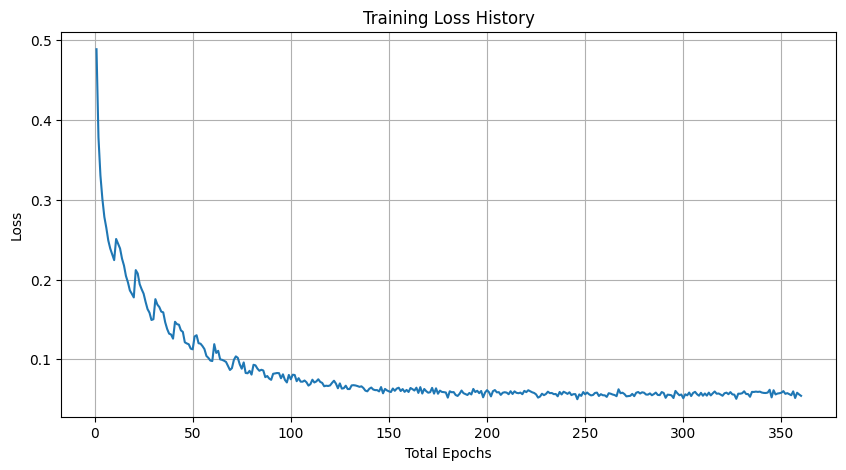

Best result: 0.9005 at iteration 7
Prediction saved to y_pred_20250805_232337.csv


In [27]:
plt_loss_history(loss_history, n, epochs)
print(f"Best result: {best_result:.4f} at iteration {best_n}")
# 전체 10000개 샘플에 대한 예측을 저장 (대회 제출 형식)
np.savetxt(y_pred_filename, y_pred_mapped, fmt="%d")
print(f"Prediction saved to {max_y_pred_filename}")